<a href="https://colab.research.google.com/github/saba-sohail/Pfizer-Vaccination-Rates/blob/main/Pfizer_Vaccination_Rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
import plotly.express as px
from catboost import CatBoostRegressor

In [3]:
drive.mount('/content/drive')
file_path1 = '/content/drive/MyDrive/Colab Notebooks/Weekly_Cumulative_Influenza_Vaccination_Coverage__Children_6_months_through_17_years__United_States_20240826.csv'
file_path2 = '/content/drive/MyDrive/Colab Notebooks/Weekly_Cumulative_Influenza_Vaccination_Coverage__Adults_18_and_Older__United_States_20240826.csv'

df_ped = pd.read_csv(file_path1)
df_adult = pd.read_csv(file_path2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_ped.columns.sort_values()
df_adult.columns.sort_values()

Index(['95 CI (%)', 'CI_Half_width_95pct', 'Current_Season_Week_Ending',
       'Demographic_Level', 'Demographic_Level_Sort', 'Demographic_Name',
       'Demographic_Name_Sort', 'Geographic_Level', 'Geographic_Name',
       'Geographic_Sort', 'Indicator_Category_Label',
       'Indicator_Category_Label_Sort', 'Indicator_Label', 'Influenza_Season',
       'Legend', 'Legend_Sort', 'Month_Week', 'ND_Weekly_Estimate',
       'Season_Sort', 'Suppression_Flag', 'Week_Ending', 'n_unweighted'],
      dtype='object')

In [5]:
df_ped.rename(columns={
        'CI_HalfWidth': 'CI_Half_width_95pct',
        'Current_Season_Week_Ending_Label': 'Current_Season_Week_Ending',
        'Demographic_Level_Sort_Order': 'Demographic_Level_Sort',
        'Demographic_Name_Sort_Order': 'Demographic_Name_Sort',
        'Geography_Level': 'Geographic_Level',
        'Geography_Name': 'Geographic_Name',
        'geography_level_sort_order': 'Geographic_Sort',
        'Indicator Category Label': 'Indicator_Category_Label',
        'Legend_Label': 'Legend',
        'Point_Estimate': 'ND_Weekly_Estimate'
        }, inplace=True)

df_ped['ND_Weekly_Estimate'] = df_ped['ND_Weekly_Estimate'] * 100

df = pd.concat([df_adult,df_ped],ignore_index=True)

In [7]:
df.describe()

,ND_Weekly_Estimate,CI_Half_width_95pct,n_unweighted,Suppression_Flag,Indicator_Category_Label_Sort,Demographic_Level_Sort,Demographic_Name_Sort,Geographic_Sort,Season_Sort,Legend_Sort,n_weighted,geography_name_order
count,21508.000000,21508.000000,21781.000000,21787.000000,13279.000000,21795.000000,21795.000000,21795.000000,21795.000000,2.179500e+04,4.262000e+03,4262.000000
mean,32.176169,3.944203,20764.399293,0.012852,2.360494,3.257674,7.276669,20.151594,2.484607,2.738392e+06,7.218916e+06,29.062881
std,15.719493,3.230457,58628.106300,0.112637,1.150496,3.902541,10.944091,23.454169,0.850740,8.736971e+05,1.203024e+07,24.312491
min,0.000000,0.000000,10.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.010101e+06,1.205700e+04,1.000000
25%,19.100000,1.793500,559.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.011332e+06,6.941355e+05,2.000000
50%,33.700000,3.055150,2777.000000,0.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.011332e+06,1.931946e+06,27.000000
75%,44.500000,5.013050,10186.000000,0.000000,3.000000,4.000000,11.000000,39.000000,3.000000,3.350101e+06,8.654925e+06,50.000000
max,78.400000,51.219300,437204.000000,1.000000,4.000000,14.000000,39.000000,74.000000,3.000000,3.740101e+06,7.060927e+07,74.000000


In [8]:
df.columns

Index(['Geographic_Level', 'Geographic_Name', 'Demographic_Level',
       'Demographic_Name', 'Indicator_Label', 'Indicator_Category_Label',
       'Month_Week', 'Week_Ending', 'ND_Weekly_Estimate',
       'CI_Half_width_95pct', 'n_unweighted', 'Suppression_Flag',
       'Current_Season_Week_Ending', 'Influenza_Season', 'Legend', '95 CI (%)',
       'Indicator_Category_Label_Sort', 'Demographic_Level_Sort',
       'Demographic_Name_Sort', 'Geographic_Sort', 'Season_Sort',
       'Legend_Sort', 'n_weighted', 'geography_name_order'],
      dtype='object')

In [9]:
df['Indicator_Category_Label_Sort'].unique()

array([ 4.,  2.,  3.,  1., nan])

In [10]:
df.sample(n=10, random_state=1234)

,Geographic_Level,Geographic_Name,Demographic_Level,Demographic_Name,Indicator_Label,Indicator_Category_Label,Month_Week,Week_Ending,ND_Weekly_Estimate,CI_Half_width_95pct,...,Legend,95 CI (%),Indicator_Category_Label_Sort,Demographic_Level_Sort,Demographic_Name_Sort,Geographic_Sort,Season_Sort,Legend_Sort,n_weighted,geography_name_order
2829,National,National,Sex,Female,Up-to-date,Yes,November Week 2,NaN,37.7,0.6849,...,"2023-2024, National, Sex: Female",37.0 - 38.4,NaN,12,31,1,3,3011231,NaN,NaN
8299,State,Utah,Overall,18+ years,4-level vaccination and intent,Definitely will get a vaccine,November Week 2,NaN,11.9,7.9538,...,"2023-2024, Utah, Overall (18+ years)",4.0 - 19.9,2.0,1,1,59,3,3590101,NaN,NaN
6663,National,National,Health Insurance,Insured,Up-to-date,Yes,May,NaN,49.6,0.8000,...,"2022-2023, National, Health Insurance: Insured",48.8 - 50.4,NaN,8,16,1,2,2010816,NaN,NaN
8612,State,Alabama,Overall,18+ years,Up-to-date,Yes,November Week 3,NaN,33.2,2.3186,...,"2023-2024, Alabama, Overall (18+ years)",30.9 - 35.6,NaN,1,1,12,3,3120101,NaN,NaN
17269,National,National,Age,65+ years,Up-to-date,Yes,April Week 4,NaN,73.1,1.2225,...,"2023-2024, National, Age (3 Level): 65+ years",71.9 - 74.3,NaN,3,11,1,3,3010311,NaN,NaN
1200,National,National,Sex,Female,4-level vaccination and intent,Probably will get a vaccine or are unsure,November Week 4,NaN,17.9,2.4372,...,"2023-2024, National, Sex: Female",15.4 - 20.3,3.0,12,31,1,3,3011231,NaN,NaN
16234,State,North Dakota,Overall,18+ years,Up-to-date,Yes,March Week 5,NaN,48.2,2.1959,...,"2023-2024, North Dakota, Overall (18+ years)",46.0 - 50.4,NaN,1,1,47,3,3470101,NaN,NaN
19210,State,Mississippi,Overall,Overall,Up-to-date,Yes,December Week 1,2023-12-02,28.6,3.7069,...,"2023-2024, Mississippi. Overall (6 months-17 y...",24.8 - 32.3,NaN,1,1,3,1,1370101,625029.0,37.0
10464,Region,Region 9,Overall,18+ years,4-level vaccination and intent,Received a vaccination,December Week 4,NaN,41.5,1.8994,...,"2023-2024, Region 9, Overall (18+ years)",39.6 - 43.4,1.0,1,1,10,3,3100101,NaN,NaN
5339,National,National,Poverty Status,Below Poverty,Up-to-date,Yes,November Week 1,NaN,21.8,0.9803,...,"2023-2024, National, Poverty Status: Below Pov...",20.9 - 22.8,NaN,10,20,1,3,3011020,NaN,NaN


In [11]:
for column in df.columns:
    print("\n")
    print(str(column) + ": " + str(df[column].unique()))



Geographic_Level: ['State' 'Substate' 'National' 'Region']


Geographic_Name: ['Arizona' 'Arkansas' 'California' 'Colorado' 'Connecticut' 'Delaware'
 'District of Columbia' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Puerto Rico' 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee'
 'Texas' 'Utah' 'Vermont' 'Virginia' 'Washington' 'West Virginia'
 'Wisconsin' 'Wyoming' 'Illinois-City of Chicago' 'Illinois-Rest of State'
 'New York-New York City' 'New York-Rest of State'
 'Pennsylvania-Philadelphia County' 'Pennsylvania-Rest of State'
 'Texas-Bexar County' 'Texas-City of Houston' 'Texas-Rest of State'
 'National' 'Region 1' 'Region 10' 'Region 2' 'Region 3' 'Region 4'
 'Region 5' 'Regi

In [12]:
df.columns

Index(['Geographic_Level', 'Geographic_Name', 'Demographic_Level',
       'Demographic_Name', 'Indicator_Label', 'Indicator_Category_Label',
       'Month_Week', 'Week_Ending', 'ND_Weekly_Estimate',
       'CI_Half_width_95pct', 'n_unweighted', 'Suppression_Flag',
       'Current_Season_Week_Ending', 'Influenza_Season', 'Legend', '95 CI (%)',
       'Indicator_Category_Label_Sort', 'Demographic_Level_Sort',
       'Demographic_Name_Sort', 'Geographic_Sort', 'Season_Sort',
       'Legend_Sort', 'n_weighted', 'geography_name_order'],
      dtype='object')

In [13]:
print(df['Indicator_Label'].unique())

['4-level vaccination and intent' 'Up-to-date']


In [14]:
print(df['Indicator_Category_Label'].unique())

['Definitely or probably will not get a vaccine'
 'Definitely will get a vaccine'
 'Probably will get a vaccine or are unsure' 'Received a vaccination'
 'Yes']


In [15]:
print(df['Indicator_Category_Label_Sort'].unique())

[ 4.  2.  3.  1. nan]


In [16]:
print("NaN Indicator Catgeory Label_Sort: " + str(21794 - df['Indicator_Category_Label_Sort'].count()))

NaN Indicator Catgeory Label_Sort: 8515


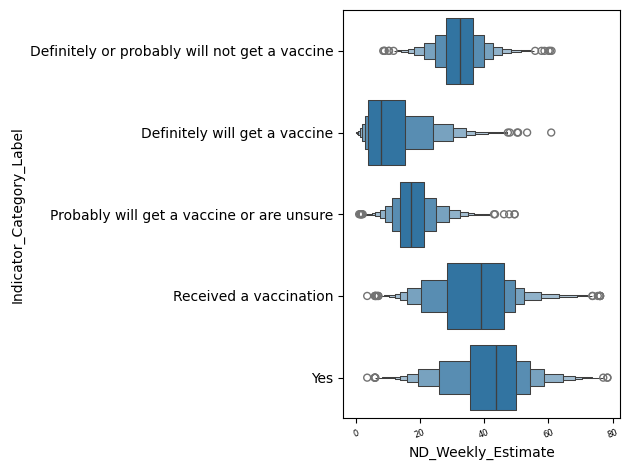

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.boxenplot(data=df, x='ND_Weekly_Estimate', y='Indicator_Category_Label', ax=ax)
plt.xticks(fontsize=6,rotation=20)
plt.tight_layout()
plt.show()

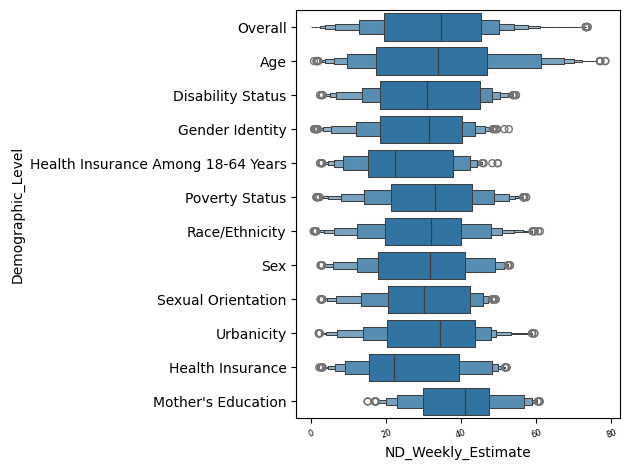

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.boxenplot(data=df, x='ND_Weekly_Estimate', y='Demographic_Level', ax=ax)
plt.xticks(fontsize=6,rotation=20)
plt.tight_layout()
plt.show()

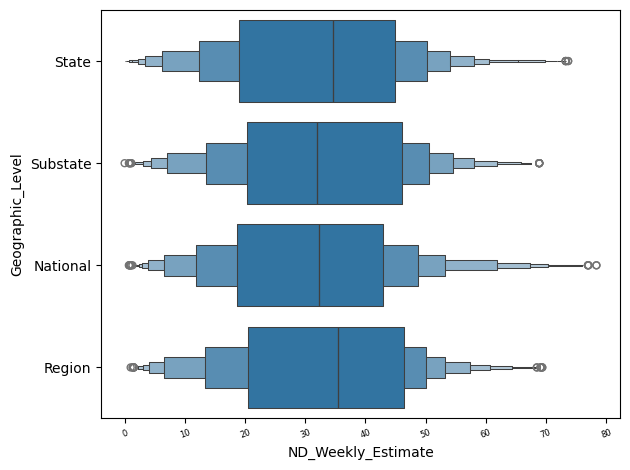

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.boxenplot(data=df, x='ND_Weekly_Estimate', y='Geographic_Level', ax=ax)
plt.xticks(fontsize=6,rotation=20)
plt.tight_layout()
plt.show()

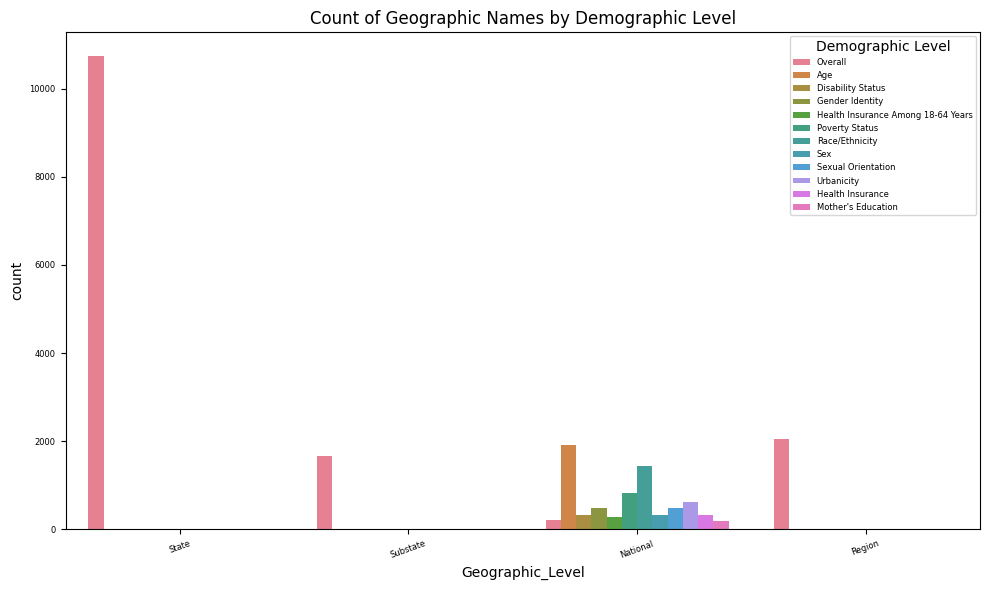

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Geographic_Level', hue='Demographic_Level')
plt.xticks(fontsize=6, rotation=20)
plt.yticks(fontsize=6)
plt.title('Count of Geographic Names by Demographic Level')
plt.legend(title='Demographic Level', fontsize=6)
plt.tight_layout()
plt.show()

In [21]:
df['Demographic_Name'].unique()

array(['18+ years', '18-29 years', '18-49 years', '30-39 years',
       '40-49 years', '50-64 years', '60+ years', '65+ years',
       '65-74 years', '75+ years', 'No', 'Yes', 'Cisgender', 'Uninsured',
       'Above Poverty, Income < $75k', 'Above Poverty, Income >= $75k',
       'Below Poverty', 'Poverty Status Unknown',
       'American Indian/Alaska Native, Non-Hispanic',
       'Asian, Non-Hispanic', 'Black, Non-Hispanic', 'Hispanic',
       'Multiple or Other Races, Non-Hispanic', 'Other, Non-Hispanic',
       'Pacific Islander/Native Hawaiian, Non-Hispanic',
       'White, Non-Hispanic', 'Female', 'Male', "Don't Know/Refused",
       'Gay/Lesbian/Bisexual/Other', 'Straight', 'Rural (Non-MSA)',
       'Suburban (MSA Non-Principal City)', 'Urban (MSA Principal City)',
       'Transgender/Nonbinary', 'Insured', '6 months-4 years',
       '6-23 months', '>= College degree', 'High school or equivalent',
       'Less than high school', 'Overall', '12-17 years', '13-17 years',
       '5

In [22]:
df['Demographic_Level'].value_counts()

,count
Demographic_Level,
Overall,14658
Age,1905
Race/Ethnicity,1434
Poverty Status,816
Urbanicity,612
Gender Identity,477
Sexual Orientation,477
Disability Status,318
Sex,318


In [23]:
df['Demographic_Name'].value_counts()

,count
Demographic_Name,
18+ years,11386
Overall,3272
50-64 years,318
Don't Know/Refused,318
Uninsured,300
Insured,300
Urban (MSA Principal City),204
Suburban (MSA Non-Principal City),204
Rural (Non-MSA),204


In [24]:
df['Current_Season_Week_Ending'].unique()

array(['01/27/2024 12:00:00 AM', '02/03/2024 12:00:00 AM',
       '01/06/2024 12:00:00 AM', '01/13/2024 12:00:00 AM',
       '01/20/2024 12:00:00 AM', '11/18/2023 12:00:00 AM',
       '11/25/2023 12:00:00 AM', '12/02/2023 12:00:00 AM',
       '10/07/2023 12:00:00 AM', '10/14/2023 12:00:00 AM',
       '10/21/2023 12:00:00 AM', '10/28/2023 12:00:00 AM',
       '11/04/2023 12:00:00 AM', '11/11/2023 12:00:00 AM',
       '09/30/2023 12:00:00 AM', '12/16/2023 12:00:00 AM',
       '02/10/2024 12:00:00 AM', '12/09/2023 12:00:00 AM',
       '03/16/2024 12:00:00 AM', '04/13/2024 12:00:00 AM',
       '12/23/2023 12:00:00 AM', '12/30/2023 12:00:00 AM',
       '05/11/2024 12:00:00 AM', '06/15/2024 12:00:00 AM',
       '03/02/2024 12:00:00 AM', '02/17/2024 12:00:00 AM',
       '03/09/2024 12:00:00 AM', '02/24/2024 12:00:00 AM',
       '03/31/2024 12:00:00 AM', '05/04/2024 12:00:00 AM',
       '03/23/2024 12:00:00 AM', '04/20/2024 12:00:00 AM',
       '04/06/2024 12:00:00 AM', '04/27/2024 12:00:00 AM

In [25]:
df.shape

(21795, 24)

In [26]:
nan_count = np.sum(df.isnull(), axis = 0)
print(nan_count)

Geographic_Level                     0
Geographic_Name                      0
Demographic_Level                    0
Demographic_Name                     0
Indicator_Label                      0
Indicator_Category_Label             0
Month_Week                           0
Week_Ending                      17533
ND_Weekly_Estimate                 287
CI_Half_width_95pct                287
n_unweighted                        14
Suppression_Flag                     8
Current_Season_Week_Ending           0
Influenza_Season                     0
Legend                               0
95 CI (%)                           93
Indicator_Category_Label_Sort     8516
Demographic_Level_Sort               0
Demographic_Name_Sort                0
Geographic_Sort                      0
Season_Sort                          0
Legend_Sort                          0
n_weighted                       17533
geography_name_order             17533
dtype: int64


In [27]:
df.shape

(21795, 24)

In [28]:
df.dropna(subset=['95 CI (%)'], inplace=True)

In [29]:
print(np.sum(df['95 CI (%)'].isnull(), axis=0))

0


In [30]:
df.shape

(21702, 24)

In [ ]:
n_mean = df['n_unweighted'].mean()
df['n_unweighted'].fillna(value=n_mean, inplace=True)

In [32]:
print(np.sum(df['n_unweighted'].isnull(), axis=0))

0


In [ ]:
nd_mean = df['ND_Weekly_Estimate'].mean()
df['ND_Weekly_Estimate'].fillna(value=nd_mean, inplace=True)
print(np.sum(df['ND_Weekly_Estimate'].isnull(), axis=0))

In [ ]:
suppression_mean = df['Suppression_Flag'].mean()
df['Suppression_Flag'].fillna(value=suppression_mean, inplace=True)
print(np.sum(df['Suppression_Flag'].isnull(), axis=0))

In [ ]:
ci_half_width_mean = df['CI_Half_width_95pct'].mean()
df['CI_Half_width_95pct'].fillna(value=ci_half_width_mean, inplace=True)
print(np.sum(df['CI_Half_width_95pct'].isnull(), axis=0))

In [ ]:
df['Indicator_Category_Label_Sort'].fillna(value=0, inplace=True)
print(np.sum(df['Indicator_Category_Label_Sort'].isnull(), axis=0))

In [37]:
nan_count = np.sum(df.isnull(), axis = 0)
print(nan_count)

Geographic_Level                     0
Geographic_Name                      0
Demographic_Level                    0
Demographic_Name                     0
Indicator_Label                      0
Indicator_Category_Label             0
Month_Week                           0
Week_Ending                      17440
ND_Weekly_Estimate                   0
CI_Half_width_95pct                  0
n_unweighted                         0
Suppression_Flag                     0
Current_Season_Week_Ending           0
Influenza_Season                     0
Legend                               0
95 CI (%)                            0
Indicator_Category_Label_Sort        0
Demographic_Level_Sort               0
Demographic_Name_Sort                0
Geographic_Sort                      0
Season_Sort                          0
Legend_Sort                          0
n_weighted                       17440
geography_name_order             17440
dtype: int64


In [38]:
df.head()

,Geographic_Level,Geographic_Name,Demographic_Level,Demographic_Name,Indicator_Label,Indicator_Category_Label,Month_Week,Week_Ending,ND_Weekly_Estimate,CI_Half_width_95pct,...,Legend,95 CI (%),Indicator_Category_Label_Sort,Demographic_Level_Sort,Demographic_Name_Sort,Geographic_Sort,Season_Sort,Legend_Sort,n_weighted,geography_name_order
0,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely or probably will not get a vaccine,January Week 4,NaN,30.8,7.8784,...,"2023-2024, Arizona, Overall (18+ years)",22.9 - 38.7,4.0,1,1,14,3,3140101,NaN,NaN
1,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely will get a vaccine,January Week 4,NaN,6.8,4.1669,...,"2023-2024, Arizona, Overall (18+ years)",2.6 - 11.0,2.0,1,1,14,3,3140101,NaN,NaN
2,State,Arizona,Overall,18+ years,4-level vaccination and intent,Probably will get a vaccine or are unsure,January Week 4,NaN,22.3,7.6134,...,"2023-2024, Arizona, Overall (18+ years)",14.7 - 29.9,3.0,1,1,14,3,3140101,NaN,NaN
3,State,Arizona,Overall,18+ years,4-level vaccination and intent,Received a vaccination,January Week 4,NaN,40.1,1.8745,...,"2023-2024, Arizona, Overall (18+ years)",38.2 - 41.9,1.0,1,1,14,3,3140101,NaN,NaN
4,State,Arizona,Overall,18+ years,Up-to-date,Yes,January Week 4,NaN,40.1,1.8745,...,"2023-2024, Arizona, Overall (18+ years)",38.2 - 41.9,0.0,1,1,14,3,3140101,NaN,NaN


In [39]:
df = df.drop(columns=['Week_Ending','n_weighted','geography_name_order'])

In [40]:
nan_count = np.sum(df.isnull(), axis = 0)
print(nan_count)

Geographic_Level                 0
Geographic_Name                  0
Demographic_Level                0
Demographic_Name                 0
Indicator_Label                  0
Indicator_Category_Label         0
Month_Week                       0
ND_Weekly_Estimate               0
CI_Half_width_95pct              0
n_unweighted                     0
Suppression_Flag                 0
Current_Season_Week_Ending       0
Influenza_Season                 0
Legend                           0
95 CI (%)                        0
Indicator_Category_Label_Sort    0
Demographic_Level_Sort           0
Demographic_Name_Sort            0
Geographic_Sort                  0
Season_Sort                      0
Legend_Sort                      0
dtype: int64


In [41]:
df['Age_Group'] = df['Demographic_Name'].where(df['Demographic_Name'].str.contains('years'))
df.columns

Index(['Geographic_Level', 'Geographic_Name', 'Demographic_Level',
       'Demographic_Name', 'Indicator_Label', 'Indicator_Category_Label',
       'Month_Week', 'ND_Weekly_Estimate', 'CI_Half_width_95pct',
       'n_unweighted', 'Suppression_Flag', 'Current_Season_Week_Ending',
       'Influenza_Season', 'Legend', '95 CI (%)',
       'Indicator_Category_Label_Sort', 'Demographic_Level_Sort',
       'Demographic_Name_Sort', 'Geographic_Sort', 'Season_Sort',
       'Legend_Sort', 'Age_Group'],
      dtype='object')

In [42]:
df['Age_Group'].unique()

array(['18+ years', '18-29 years', '18-49 years', '30-39 years',
       '40-49 years', '50-64 years', '60+ years', '65+ years',
       '65-74 years', '75+ years', nan, '6 months-4 years', '12-17 years',
       '13-17 years', '5-11 years', '5-12 years', '5-17 years'],
      dtype=object)

In [43]:
nan_count = np.sum(df.isnull(), axis = 0)
print(nan_count)

Geographic_Level                    0
Geographic_Name                     0
Demographic_Level                   0
Demographic_Name                    0
Indicator_Label                     0
Indicator_Category_Label            0
Month_Week                          0
ND_Weekly_Estimate                  0
CI_Half_width_95pct                 0
n_unweighted                        0
Suppression_Flag                    0
Current_Season_Week_Ending          0
Influenza_Season                    0
Legend                              0
95 CI (%)                           0
Indicator_Category_Label_Sort       0
Demographic_Level_Sort              0
Demographic_Name_Sort               0
Geographic_Sort                     0
Season_Sort                         0
Legend_Sort                         0
Age_Group                        8529
dtype: int64


In [44]:
df['Age_Group'] = df['Age_Group'].fillna(0)
df['Age_Group'] = df['Age_Group'].replace({
    '6 months-4 years': 1,
    '5-11 years': 2,
    '5-12 years': 3,
    '5-17 years' : 4,
    '12-17 years' : 5,
    '13-17 years' : 6,
    '18+ years' : 7,
    '18-29 years' : 8,
    '18-49 years' : 9,
    '30-39 years' : 10,
    '40-49 years' : 11,
    '50-64 years' : 12,
    '60+ years' : 13,
    '65+ years' : 14,
    '65-74 years' : 15,
    '75+ years' : 16
})

<ipython-input-44-4d3ff32c896d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Age_Group'] = df['Age_Group'].replace({


In [45]:
df['Month_Week'].unique()

array(['January Week 4', 'February Week 1', 'January Week 1',
       'January Week 2', 'January Week 3', 'November Week 3',
       'November Week 4', 'December Week 1', 'October Week 2',
       'October Week 3', 'October Week 4', 'October Week 5',
       'November Week 1', 'November Week 2', 'October Week 1', 'October',
       'November', 'December', 'February', 'December Week 2', 'March',
       'April', 'January', 'December Week 3', 'December Week 4',
       'December Week 5', 'May', 'June', 'March Week 1',
       'February Week 2', 'February Week 3', 'March Week 2',
       'March Week 3', 'February Week 4', 'March Week 5', 'May Week 1',
       'May Week 2', 'March Week 4', 'April Week 2', 'April Week 3',
       'April Week 1', 'April Week 4'], dtype=object)

In [46]:
df['Month'] = df['Month_Week'].str.extract(r'([A-Za-z]+)')[0]
df['Month'] = df['Month'].str.strip()
df['Month'].unique()

array(['January', 'February', 'November', 'December', 'October', 'March',
       'April', 'May', 'June'], dtype=object)

In [47]:
df['Month'] = df['Month'].replace({
    'January' : 1,
    'February' : 2,
    'November' : 11,
    'December' : 12,
    'October' : 10,
    'March' : 3,
    'April' : 4,
    'May' : 5,
    'June' : 6
})

<ipython-input-47-717b994f7c8b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Month'] = df['Month'].replace({


In [48]:
df['Geographic_Name'].unique()

array(['Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming',
       'Illinois-City of Chicago', 'Illinois-Rest of State',
       'New York-New York City', 'New York-Rest of State',
       'Pennsylvania-Philadelphia County', 'Pennsylvania-Rest of State',
       'Texas-Bexar County', 'Texas-City of Houston',
       'Texas-Rest of State', 'National', '

In [49]:
df['Geographic_Level'].value_counts()

,count
Geographic_Level,
State,10667
National,7321
Region,2040
Substate,1674


In [50]:
df['Age_Group'].value_counts()

,count
Age_Group,
7,11313
0,8529
12,318
14,159
16,159
8,159
15,159
13,159
11,159


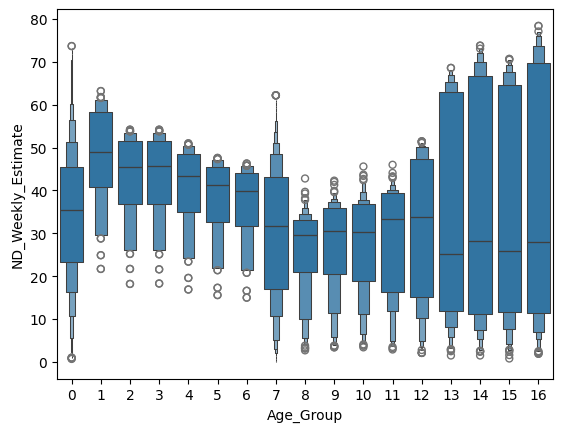

In [51]:
sns.boxenplot(data=df, x='Age_Group', y='ND_Weekly_Estimate')
plt.show()

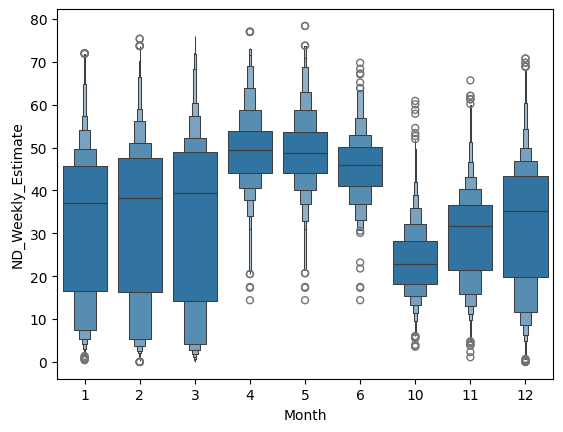

In [52]:
sns.boxenplot(data=df, x='Month', y='ND_Weekly_Estimate')
plt.show()

In [53]:
df_geographic_name = pd.get_dummies(df['Geographic_Name'], prefix='Geographic_Name_')
df = df.join(df_geographic_name)
df.drop(columns = 'Geographic_Name', inplace=True)

In [54]:
df_indicator_category_label = pd.get_dummies(df['Indicator_Category_Label'], prefix='Indicator_Category_Label_')
df = df.join(df_indicator_category_label)
df.drop(columns = 'Indicator_Category_Label', inplace=True)

<ipython-input-55-8520a4469a18>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


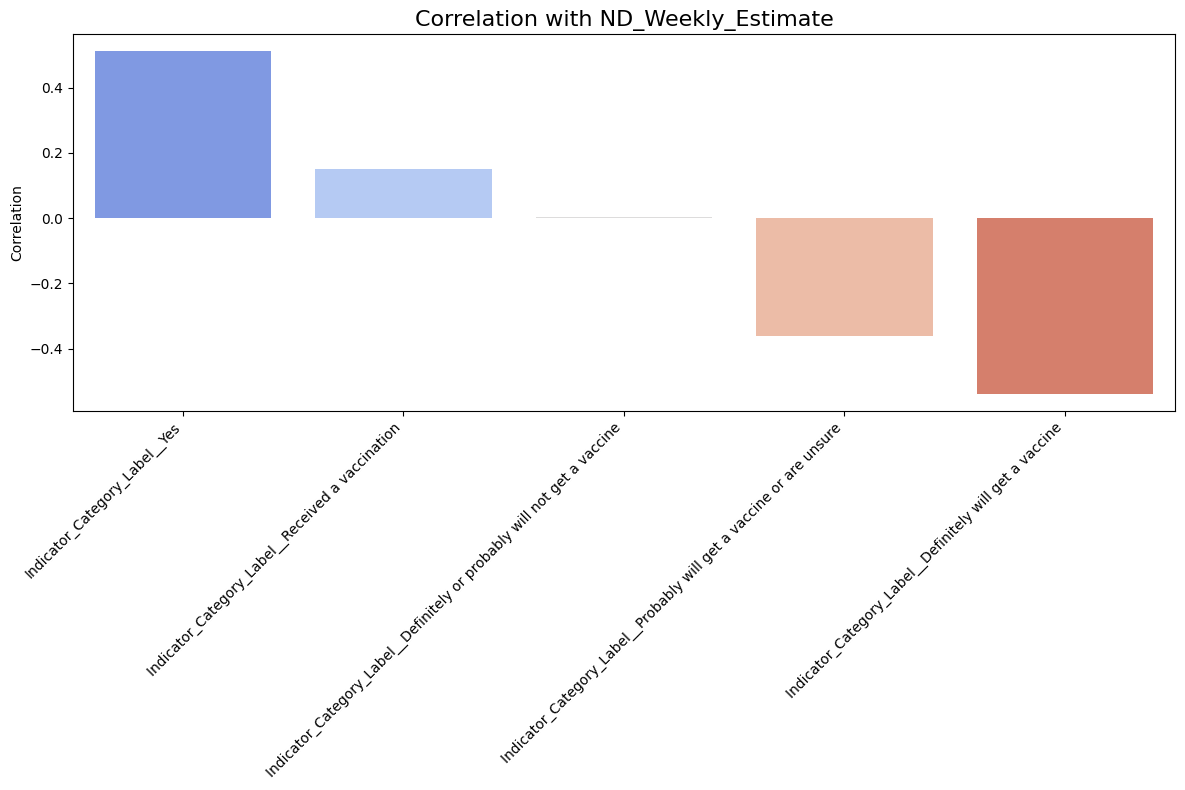

In [55]:
filtered_features = [
    feature for feature in df.columns
    if feature.startswith("Indicator_Category_Label__")
]
if 'ND_Weekly_Estimate' not in filtered_features:
    filtered_features.append('ND_Weekly_Estimate')

df_features = df[filtered_features]
correlation_matrix = df_features.corr()
nd_weekly_correlations = correlation_matrix["ND_Weekly_Estimate"].drop("ND_Weekly_Estimate")

sorted_correlations = nd_weekly_correlations.sort_values(ascending=False)
correlation_df = sorted_correlations.reset_index()
correlation_df.columns = ["Variable", "Correlation"]

plt.figure(figsize=(12, 8))
sns.barplot(
    data=correlation_df,
    x="Variable",
    y="Correlation",
    palette="coolwarm"
)

plt.title("Correlation with ND_Weekly_Estimate", fontsize=16)
plt.xlabel("")
plt.ylabel("Correlation")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

In [56]:
df_demographic_name = pd.get_dummies(df['Demographic_Name'], prefix='Demographic_Name_')
df = df.join(df_demographic_name)
df.drop(columns = 'Demographic_Name', inplace=True)

In [57]:
df_influenza_season = pd.get_dummies(df['Influenza_Season'], prefix='Influenza_Season_')
df = df.join(df_influenza_season)
df.drop(columns = 'Influenza_Season', inplace=True)

In [58]:
feature_list = list(df.select_dtypes(include=['float64','boolean', 'int']).columns)
feature_list.remove('ND_Weekly_Estimate')
feature_list.remove('n_unweighted')
feature_list.remove('CI_Half_width_95pct')
feature_list.remove('Season_Sort')
feature_list.remove('Indicator_Category_Label_Sort')
feature_list.remove('Demographic_Name_Sort')
feature_list.remove('Geographic_Sort')
feature_list.remove('Legend_Sort')
feature_list.remove('Demographic_Name__Overall')
feature_list.remove('Demographic_Name__Yes')
feature_list.remove('Demographic_Level_Sort')
feature_list.remove('Suppression_Flag')
feature_list.remove('Indicator_Category_Label__Yes')
demographic_ages = ['Demographic_Name__12-17 years',
                      'Demographic_Name__13-17 years',
                      'Demographic_Name__18+ years',
                      'Demographic_Name__18-29 years',
                      'Demographic_Name__18-49 years',
                      'Demographic_Name__30-39 years',
                      'Demographic_Name__40-49 years',
                      'Demographic_Name__5-11 years',
                      'Demographic_Name__5-12 years',
                      'Demographic_Name__5-17 years',
                      'Demographic_Name__50-64 years',
                      'Demographic_Name__6 months-4 years',
                      'Demographic_Name__6-23 months',
                      'Demographic_Name__60+ years',
                      'Demographic_Name__65+ years',
                      'Demographic_Name__65-74 years',
                      'Demographic_Name__75+ years' ]
for age_feature in demographic_ages:
  if age_feature in feature_list: #remove only if item is in feature_list
    feature_list.remove(age_feature)

In [59]:
y = df['ND_Weekly_Estimate']
X = df[feature_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=1234)

In [60]:
df[feature_list + ['ND_Weekly_Estimate']].sample(n=10, random_state=1234)

,Age_Group,Month,Geographic_Name__Alabama,Geographic_Name__Alaska,Geographic_Name__Arizona,Geographic_Name__Arkansas,Geographic_Name__California,Geographic_Name__Colorado,Geographic_Name__Connecticut,Geographic_Name__Delaware,...,Demographic_Name__Straight,Demographic_Name__Suburban (MSA Non-Principal City),Demographic_Name__Transgender/Nonbinary,Demographic_Name__Uninsured,Demographic_Name__Urban (MSA Principal City),"Demographic_Name__White, Non-Hispanic",Influenza_Season__2021-2022,Influenza_Season__2022-2023,Influenza_Season__2023-2024,ND_Weekly_Estimate
12897,7,2,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,39.8
14175,11,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,38.1
11384,7,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,48.1
4552,0,11,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,28.4
16788,7,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3.7
2666,0,10,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,24.7
15120,7,5,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,52.1
12383,0,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,41.0
10964,7,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,49.3
18207,0,11,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,35.6


In [61]:
feature_list

['Age_Group',
 'Month',
 'Geographic_Name__Alabama',
 'Geographic_Name__Alaska',
 'Geographic_Name__Arizona',
 'Geographic_Name__Arkansas',
 'Geographic_Name__California',
 'Geographic_Name__Colorado',
 'Geographic_Name__Connecticut',
 'Geographic_Name__Delaware',
 'Geographic_Name__District of Columbia',
 'Geographic_Name__Florida',
 'Geographic_Name__Georgia',
 'Geographic_Name__Guam',
 'Geographic_Name__Hawaii',
 'Geographic_Name__Idaho',
 'Geographic_Name__Illinois',
 'Geographic_Name__Illinois-City of Chicago',
 'Geographic_Name__Illinois-Rest of State',
 'Geographic_Name__Indiana',
 'Geographic_Name__Iowa',
 'Geographic_Name__Kansas',
 'Geographic_Name__Kentucky',
 'Geographic_Name__Louisiana',
 'Geographic_Name__Maine',
 'Geographic_Name__Maryland',
 'Geographic_Name__Massachusetts',
 'Geographic_Name__Michigan',
 'Geographic_Name__Minnesota',
 'Geographic_Name__Mississippi',
 'Geographic_Name__Missouri',
 'Geographic_Name__Montana',
 'Geographic_Name__National',
 'Geographic_Na

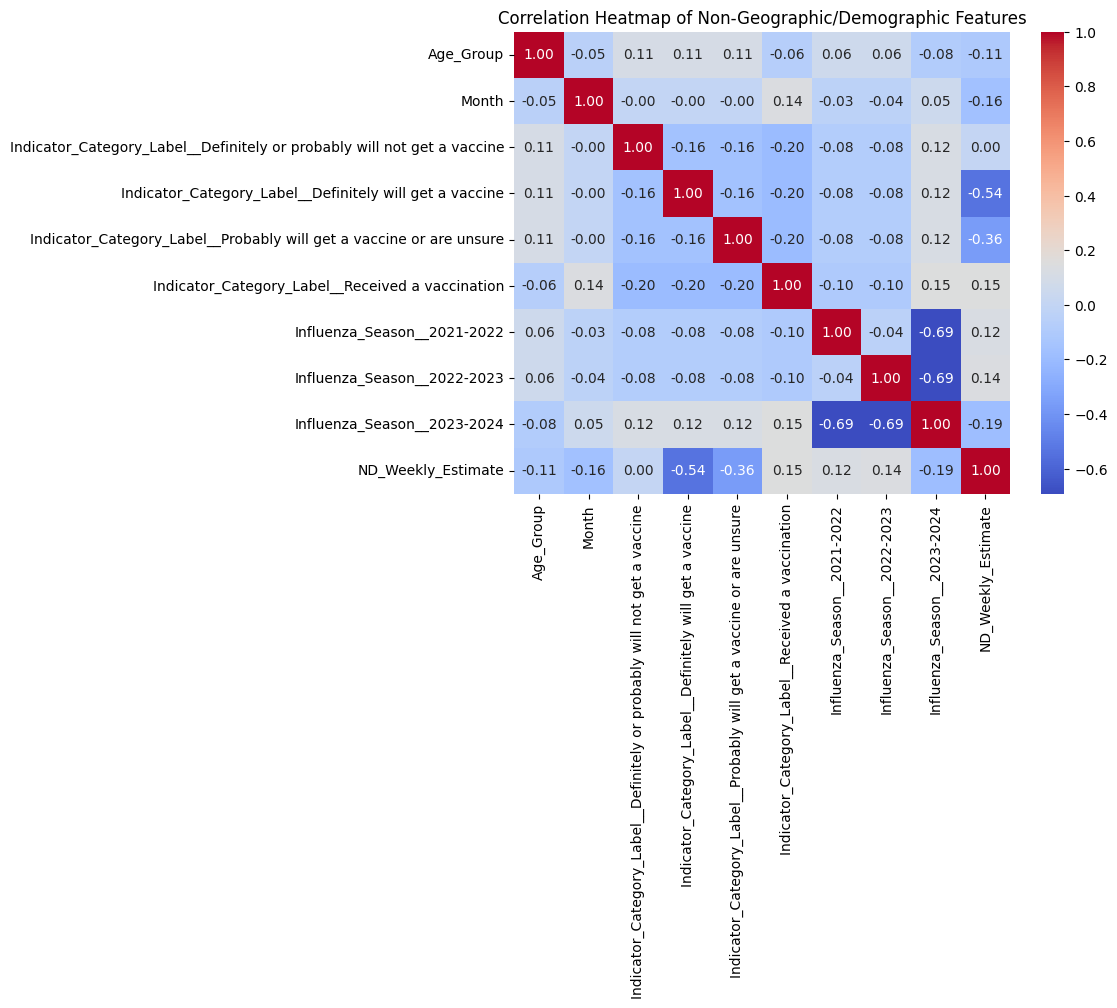

In [62]:
filtered_features = [
    feature for feature in feature_list
    if "Geographic_Name__" not in feature and "Demographic_Name__" not in feature
]

filtered_features.append('ND_Weekly_Estimate')
df_features = df[filtered_features]
correlation_matrix = df_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Non-Geographic/Demographic Features")
plt.show()

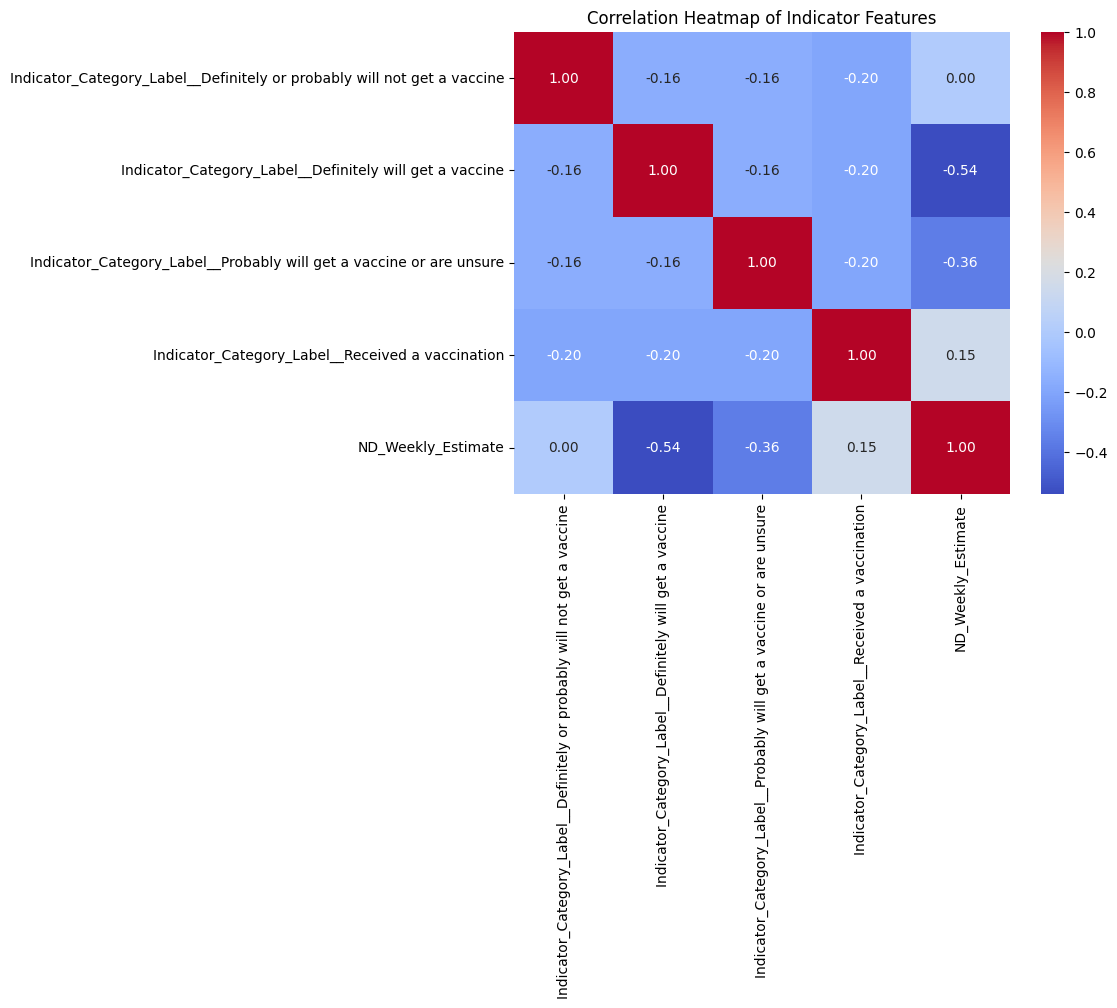

In [63]:
filtered_features = [
    feature for feature in feature_list
    if feature.startswith("Indicator_Category_Label__")
]
if 'ND_Weekly_Estimate' not in filtered_features:
    filtered_features.append('ND_Weekly_Estimate')
df_features = df[filtered_features]
correlation_matrix = df_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Indicator Features")
plt.show()

In [64]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
predictions_dt = dt_model.predict(X_test)
mae_dt = mean_absolute_error(y_test, predictions_dt)
r2_dt = r2_score(y_test, predictions_dt)
mse_dt = mean_squared_error(y_test, predictions_dt)
rmse_dt = root_mean_squared_error(y_test, predictions_dt)

In [65]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
predictions_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, predictions_rf)
r2_rf = r2_score(y_test, predictions_rf)
mse_rf = mean_squared_error(y_test, predictions_rf)
rmse_rf = root_mean_squared_error(y_test, predictions_rf)

In [66]:
print("Model Comparison:")
print(f"{'Metric':<15} {'Random Forest':<15} {'Decision Tree':<15}")
print(f"{'-'*45}")

print(f"{'MAE':<15} {mae_rf:<15.4f} {mae_dt:<15.4f}")
print(f"{'R² Score':<15} {r2_rf:<15.4f} {r2_dt:<15.4f}")
print(f"{'MSE':<15} {mse_rf:<15.4f} {mse_dt:<15.4f}")
print(f"{'RMSE':<15} {rmse_rf:<15.4f} {rmse_dt:<15.4f}")

Model Comparison:
Metric          Random Forest   Decision Tree  
---------------------------------------------
MAE             2.2979          2.3343         
R² Score        0.9437          0.9386         
MSE             13.7463         14.9862        
RMSE            3.7076          3.8712         


In [67]:
df_pred_test = pd.DataFrame()

In [68]:
df_pred_test['ND_Weekly_Estimate'] = y_test

In [69]:
df_pred_test['Predictions_DT'] = predictions_dt

In [70]:
df_pred_test['Predictions_RF'] = predictions_rf

In [71]:
df_pred_test.head()

,ND_Weekly_Estimate,Predictions_DT,Predictions_RF
12897,39.8,39.80,40.002267
14175,38.1,37.70,37.750867
11384,48.1,48.15,48.173561
4552,28.4,28.75,28.709479
16788,3.7,3.45,3.425367


In [72]:
forest_importances = rf_model.feature_importances_

<ipython-input-73-f430b1421771>:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


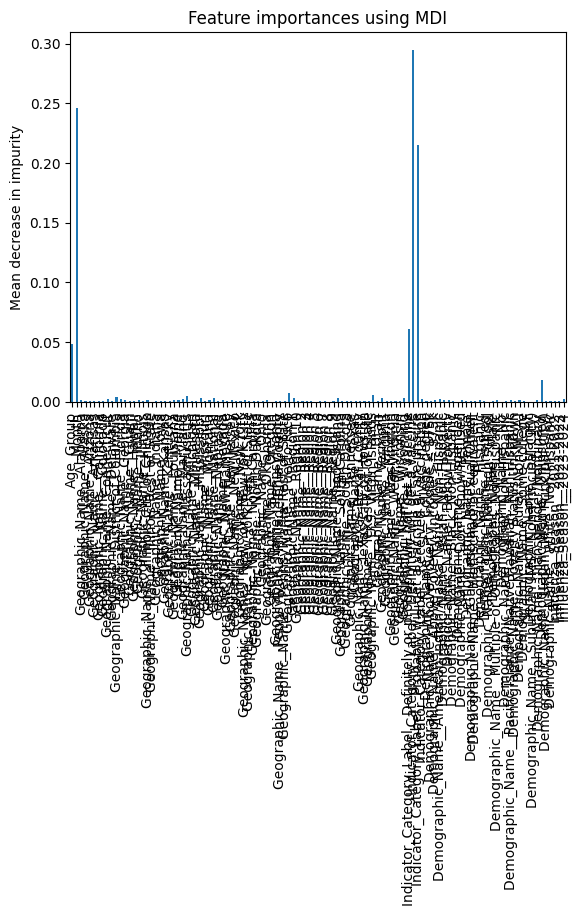

In [73]:
forest_importances_series = pd.Series(forest_importances, index=feature_list)
std = np.std([rf_model.feature_importances_ for tree in rf_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances_series.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [74]:
df_features_imp = pd.DataFrame()

In [75]:
df_features_imp['DT_importances'] = dt_model.feature_importances_

In [76]:
df_features_imp['RF_importances'] = rf_model.feature_importances_

In [77]:
df_features_imp['Feature_list'] = feature_list

In [78]:
df_features_imp.head()

,DT_importances,RF_importances,Feature_list
0,0.048097,0.048442,Age_Group
1,0.247951,0.246401,Month
2,0.001088,0.001211,Geographic_Name__Alabama
3,0.000883,0.001025,Geographic_Name__Alaska
4,0.000557,0.000583,Geographic_Name__Arizona


In [79]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
predictions_lr = lr_model.predict(X_test)
mae_lr = mean_absolute_error(y_test, predictions_lr)
r2_lr = r2_score(y_test, predictions_lr)
mse_lr = mean_squared_error(y_test, predictions_lr)
rmse_lr = root_mean_squared_error(y_test, predictions_lr)

In [80]:
print("Model Comparison:")
print(f"{'Metric':<15} {'Random Forest':<15} {'Decision Tree':<15} {'Linear Regression':<15}")
print(f"{'-'*60}")

print(f"{'MAE':<15} {mae_rf:<15.4f} {mae_dt:<15.4f} {mae_lr:<15.4f}")
print(f"{'R² Score':<15} {r2_rf:<15.4f} {r2_dt:<15.4f} {r2_lr:<15.4f}")
print(f"{'MSE':<15} {mse_rf:<15.4f} {mse_dt:<15.4f} {mse_lr:<15.4f}")
print(f"{'RMSE':<15} {rmse_rf:<15.4f} {rmse_dt:<15.4f} {rmse_lr:<15.4f}")

Model Comparison:
Metric          Random Forest   Decision Tree   Linear Regression
------------------------------------------------------------
MAE             2.2979          2.3343          7.8204         
R² Score        0.9437          0.9386          0.5785         
MSE             13.7463         14.9862         102.8690       
RMSE            3.7076          3.8712          10.1424        


In [81]:
en_model = ElasticNet()
en_model.fit(X_train, y_train)
predictions_en = en_model.predict(X_test)
mae_en = mean_absolute_error(y_test, predictions_en)
r2_en = r2_score(y_test, predictions_en)
mse_en = mean_squared_error(y_test, predictions_en)
rmse_en = np.sqrt(mse_en)

In [ ]:
cb_model = CatBoostRegressor()
cb_model.fit(X_train, y_train)
predictions_cb = cb_model.predict(X_test)
mae_cb = mean_absolute_error(y_test, predictions_cb)
r2_cb = r2_score(y_test, predictions_cb)
mse_cb = mean_squared_error(y_test, predictions_cb)
rmse_cb = np.sqrt(mse_cb)

In [83]:
print("Model Comparison:")
print(f"{'Metric':<12} {'Random Forest':<15} {'Decision Tree':<15} {'Linear Regression':<18} {'Elastic Net':<15} {'CatBoost':<15}")
print("="*90)

print(f"{'MAE':<12} {mae_rf:<15.4f} {mae_dt:<15.4f} {mae_lr:<18.4f} {mae_en:<15.4f} {mae_cb:<15.4f}")
print(f"{'R² Score':<12} {r2_rf:<15.4f} {r2_dt:<15.4f} {r2_lr:<18.4f} {r2_en:<15.4f} {r2_cb:<15.4f}")
print(f"{'MSE':<12} {mse_rf:<15.4f} {mse_dt:<15.4f} {mse_lr:<18.4f} {mse_en:<15.4f} {mse_cb:<15.4f}")
print(f"{'RMSE':<12} {rmse_rf:<15.4f} {rmse_dt:<15.4f} {rmse_lr:<18.4f} {rmse_en:<15.4f} {rmse_cb:<15.4f}")

Model Comparison:
Metric       Random Forest   Decision Tree   Linear Regression  Elastic Net     CatBoost       
MAE          2.2979          2.3343          7.8204             11.8043         2.7180         
R² Score     0.9437          0.9386          0.5785             0.1593          0.9418         
MSE          13.7463         14.9862         102.8690           205.1763        14.1960        
RMSE         3.7076          3.8712          10.1424            14.3240         3.7678         


In [84]:
df_pred_test['Predictions_LR'] = predictions_lr
df_pred_test['Predictions_EN'] = predictions_en
df_pred_test['Predictions_CB'] = predictions_cb

In [85]:
df_pred_test.head(10)

,ND_Weekly_Estimate,Predictions_DT,Predictions_RF,Predictions_LR,Predictions_EN,Predictions_CB
12897,39.8,39.800,40.002267,37.842773,35.366025,41.930452
14175,38.1,37.700,37.750867,46.635254,33.894802,40.843099
11384,48.1,48.150,48.173561,44.569824,34.192311,47.805900
4552,28.4,28.750,28.709479,34.138184,32.664999,32.338234
16788,3.7,3.450,3.425367,14.836426,30.362311,3.374666
2666,24.7,22.900,21.944807,14.584473,30.264848,24.081097
15120,52.1,52.100,51.970662,42.621094,33.020796,50.071831
12383,41.0,41.225,41.206821,41.759277,36.763106,44.291470
10964,49.3,49.300,49.318600,44.357910,34.192311,47.905996
18207,35.6,35.600,34.839058,40.294434,32.077043,36.041232


In [86]:
lr_coef = lr_model.coef_
importance_df_lr = pd.DataFrame({'Feature': feature_list, 'Coefficient': lr_coef})
importance_df_lr['Absolute Coefficient'] = importance_df_lr['Coefficient'].abs()
importance_df = importance_df_lr.sort_values(by='Absolute Coefficient', ascending=False)
importance_df

,Feature,Coefficient,Absolute Coefficient
109,Influenza_Season__2021-2022,-3.902492e+12,3.902492e+12
111,Influenza_Season__2023-2024,-3.902492e+12,3.902492e+12
110,Influenza_Season__2022-2023,-3.902492e+12,3.902492e+12
10,Geographic_Name__District of Columbia,2.554585e+11,2.554585e+11
50,Geographic_Name__Region 1,2.554585e+11,2.554585e+11
...,...,...,...
107,Demographic_Name__Urban (MSA Principal City),-1.209229e+00,1.209229e+00
1,Month,-5.563028e-01,5.563028e-01
89,Demographic_Name__Female,-3.935547e-01,3.935547e-01
0,Age_Group,-5.522866e-02,5.522866e-02


In [87]:
en_coef = en_model.coef_
importance_df_en = pd.DataFrame({'Feature': feature_list, 'Coefficient': en_coef})
importance_df_en['Absolute Coefficient'] = importance_df_en['Coefficient'].abs()
importance_df_en = importance_df_en.sort_values(by='Absolute Coefficient', ascending=False)
importance_df_en

,Feature,Coefficient,Absolute Coefficient
77,Indicator_Category_Label__Definitely will get ...,-3.830001,3.830001
78,Indicator_Category_Label__Probably will get a ...,-2.397953,2.397953
79,Indicator_Category_Label__Received a vaccination,0.587956,0.587956
1,Month,-0.585758,0.585758
0,Age_Group,-0.367256,0.367256
...,...,...,...
38,Geographic_Name__New York,0.000000,0.000000
37,Geographic_Name__New Mexico,0.000000,0.000000
36,Geographic_Name__New Jersey,0.000000,0.000000
35,Geographic_Name__New Hampshire,0.000000,0.000000


In [88]:
df_features_imp['LR_importances'] = importance_df_lr['Coefficient']
df_features_imp['EN_importances'] = importance_df_en['Coefficient']
df_features_imp['CB_importances'] = cb_model.feature_importances_ / 100

In [89]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_features_imp['Feature_list'],
    y=df_features_imp['LR_importances'],
    mode='markers',
    name='Linear Regression',
    marker=dict(color='red', symbol='circle'),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=df_features_imp['Feature_list'],
    y=df_features_imp['EN_importances'],
    mode='markers',
    name='Elastic Net',
    marker=dict(color='blue', symbol='x'),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=df_features_imp['Feature_list'],
    y=df_features_imp['RF_importances'],
    mode='markers',
    name='Random Forest',
    marker=dict(color='green', symbol='square'),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=df_features_imp['Feature_list'],
    y=df_features_imp['DT_importances'],
    mode='markers',
    name='Decision Tree',
    marker=dict(color='orange', symbol='diamond'),
    showlegend=True
))
fig.add_trace(go.Scatter(
    x=df_features_imp['Feature_list'],
    y=df_features_imp['CB_importances'],
    mode='markers',
    name='CatBoost',
    marker=dict(color='purple', symbol='star'),
    showlegend=True
))
fig.update_layout(
    title='Feature Importances Comparison: LR, EN, RF, DT, CB',
    xaxis_title='Features',
    yaxis_title='Importance',
    xaxis_tickangle=-45,
    legend_title_text='Models',
    template='plotly_white'
)


fig.show()

In [90]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test,
    y=predictions_dt,
    mode='markers',
    name='Decision Tree Predictions',
    marker=dict(color='#66c2a5', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=y_test,
    y=predictions_rf,
    mode='markers',
    name='Random Forest Predictions',
    marker=dict(color='#fc8d62', symbol='square')
))

fig.add_trace(go.Scatter(
    x=y_test,
    y=predictions_lr,
    mode='markers',
    name='Linear Regression Predictions',
    marker=dict(color='#8da0cb', symbol='x')
))

fig.add_trace(go.Scatter(
    x=y_test,
    y=predictions_en,
    mode='markers',
    name='Elastic Net Predictions',
    marker=dict(color='#e78ac3', symbol='diamond')
))

fig.add_trace(go.Scatter(
    x=y_test,
    y=predictions_cb,
    mode='markers',
    name='CatBoost Predictions',
    marker=dict(color='#a6d854', symbol='star')
))

max_value = max(y_test.max(), predictions_lr.max(), predictions_dt.max(), predictions_rf.max(), predictions_en.max(), predictions_cb.max())
min_value = min(y_test.min(), predictions_lr.min(), predictions_dt.min(), predictions_rf.min(), predictions_en.min(), predictions_cb.min())

fig.add_trace(go.Scatter(
    x=[min_value, max_value],
    y=[min_value, max_value],
    mode='lines',
    name='Perfect Prediction Line',
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    xaxis_title='Actual Values (y_test)',
    yaxis_title='Predicted Values',
    title='Model Predictions Comparison',
    legend_title_text='Models',
    template='plotly_white',
    width=800
)

fig.show()


In [91]:
df_features_imp.sort_values(by="DT_importances", ascending=False)

,DT_importances,RF_importances,Feature_list,LR_importances,EN_importances,CB_importances
77,0.296619,0.295013,Indicator_Category_Label__Definitely will get ...,-3.073962e+01,-3.830001,0.359504
1,0.247951,0.246401,Month,-5.563028e-01,-0.585758,0.238569
78,0.216530,0.214837,Indicator_Category_Label__Probably will get a ...,-2.394479e+01,-2.397953,0.218973
76,0.061498,0.061274,Indicator_Category_Label__Definitely or probab...,-9.519043e+00,-0.000000,0.074758
0,0.048097,0.048442,Age_Group,-5.522866e-02,-0.367256,0.037976
...,...,...,...,...,...,...
97,0.000149,0.000191,Demographic_Name__No,-2.800842e+00,-0.000000,0.000024
18,0.000148,0.000184,Geographic_Name__Illinois-Rest of State,2.554585e+11,-0.000000,0.000006
103,0.000142,0.000161,Demographic_Name__Straight,-2.201630e+00,-0.000000,0.000014
104,0.000139,0.000161,Demographic_Name__Suburban (MSA Non-Principal ...,-1.619675e+00,0.000000,0.000031


In [92]:
df_features_imp.sort_values(by="RF_importances", ascending=False)

,DT_importances,RF_importances,Feature_list,LR_importances,EN_importances,CB_importances
77,0.296619,0.295013,Indicator_Category_Label__Definitely will get ...,-3.073962e+01,-3.830001,0.359504
1,0.247951,0.246401,Month,-5.563028e-01,-0.585758,0.238569
78,0.216530,0.214837,Indicator_Category_Label__Probably will get a ...,-2.394479e+01,-2.397953,0.218973
76,0.061498,0.061274,Indicator_Category_Label__Definitely or probab...,-9.519043e+00,-0.000000,0.074758
0,0.048097,0.048442,Age_Group,-5.522866e-02,-0.367256,0.037976
...,...,...,...,...,...,...
87,0.000154,0.000171,Demographic_Name__Cisgender,-1.535290e+00,-0.000000,0.000006
94,0.000200,0.000166,Demographic_Name__Less than high school,-1.459839e+00,0.000000,0.000069
103,0.000142,0.000161,Demographic_Name__Straight,-2.201630e+00,-0.000000,0.000014
104,0.000139,0.000161,Demographic_Name__Suburban (MSA Non-Principal ...,-1.619675e+00,0.000000,0.000031


In [93]:
df_features_imp.sort_values(by="LR_importances", ascending=False)

,DT_importances,RF_importances,Feature_list,LR_importances,EN_importances,CB_importances
10,0.003949,0.004163,Geographic_Name__District of Columbia,2.554585e+11,0.000000,0.002389
50,0.003251,0.003293,Geographic_Name__Region 1,2.554585e+11,0.000000,0.001862
26,0.004246,0.004614,Geographic_Name__Massachusetts,2.554585e+11,0.000000,0.002525
70,0.002870,0.002991,Geographic_Name__Vermont,2.554585e+11,0.000000,0.001408
60,0.003060,0.003279,Geographic_Name__Rhode Island,2.554585e+11,0.000000,0.001632
...,...,...,...,...,...,...
78,0.216530,0.214837,Indicator_Category_Label__Probably will get a ...,-2.394479e+01,-2.397953,0.218973
77,0.296619,0.295013,Indicator_Category_Label__Definitely will get ...,-3.073962e+01,-3.830001,0.359504
110,0.000304,0.000383,Influenza_Season__2022-2023,-3.902492e+12,0.000000,0.000683
111,0.002068,0.002463,Influenza_Season__2023-2024,-3.902492e+12,-0.366004,0.002434


In [94]:
df_features_imp.sort_values(by="EN_importances", ascending=False)

,DT_importances,RF_importances,Feature_list,LR_importances,EN_importances,CB_importances
79,0.001695,0.002173,Indicator_Category_Label__Received a vaccination,-4.250305e+00,0.587956,0.002213
80,0.000738,0.000705,Demographic_Name__>= College degree,5.815918e+00,0.000000,0.000406
108,0.000338,0.000443,"Demographic_Name__White, Non-Hispanic",-1.589354e+00,-0.000000,0.000252
109,0.000376,0.000355,Influenza_Season__2021-2022,-3.902492e+12,0.000000,0.000130
76,0.061498,0.061274,Indicator_Category_Label__Definitely or probab...,-9.519043e+00,-0.000000,0.074758
...,...,...,...,...,...,...
111,0.002068,0.002463,Influenza_Season__2023-2024,-3.902492e+12,-0.366004,0.002434
0,0.048097,0.048442,Age_Group,-5.522866e-02,-0.367256,0.037976
1,0.247951,0.246401,Month,-5.563028e-01,-0.585758,0.238569
78,0.216530,0.214837,Indicator_Category_Label__Probably will get a ...,-2.394479e+01,-2.397953,0.218973


In [95]:
df_features_imp.sort_values(by="CB_importances", ascending=False)

,DT_importances,RF_importances,Feature_list,LR_importances,EN_importances,CB_importances
77,0.296619,0.295013,Indicator_Category_Label__Definitely will get ...,-3.073962e+01,-3.830001,0.359504
1,0.247951,0.246401,Month,-5.563028e-01,-0.585758,0.238569
78,0.216530,0.214837,Indicator_Category_Label__Probably will get a ...,-2.394479e+01,-2.397953,0.218973
76,0.061498,0.061274,Indicator_Category_Label__Definitely or probab...,-9.519043e+00,-0.000000,0.074758
0,0.048097,0.048442,Age_Group,-5.522866e-02,-0.367256,0.037976
...,...,...,...,...,...,...
30,0.000182,0.000301,Geographic_Name__Missouri,2.554585e+11,0.000000,0.000008
18,0.000148,0.000184,Geographic_Name__Illinois-Rest of State,2.554585e+11,-0.000000,0.000006
87,0.000154,0.000171,Demographic_Name__Cisgender,-1.535290e+00,-0.000000,0.000006
55,0.000116,0.000148,Geographic_Name__Region 5,2.554585e+11,0.000000,0.000000


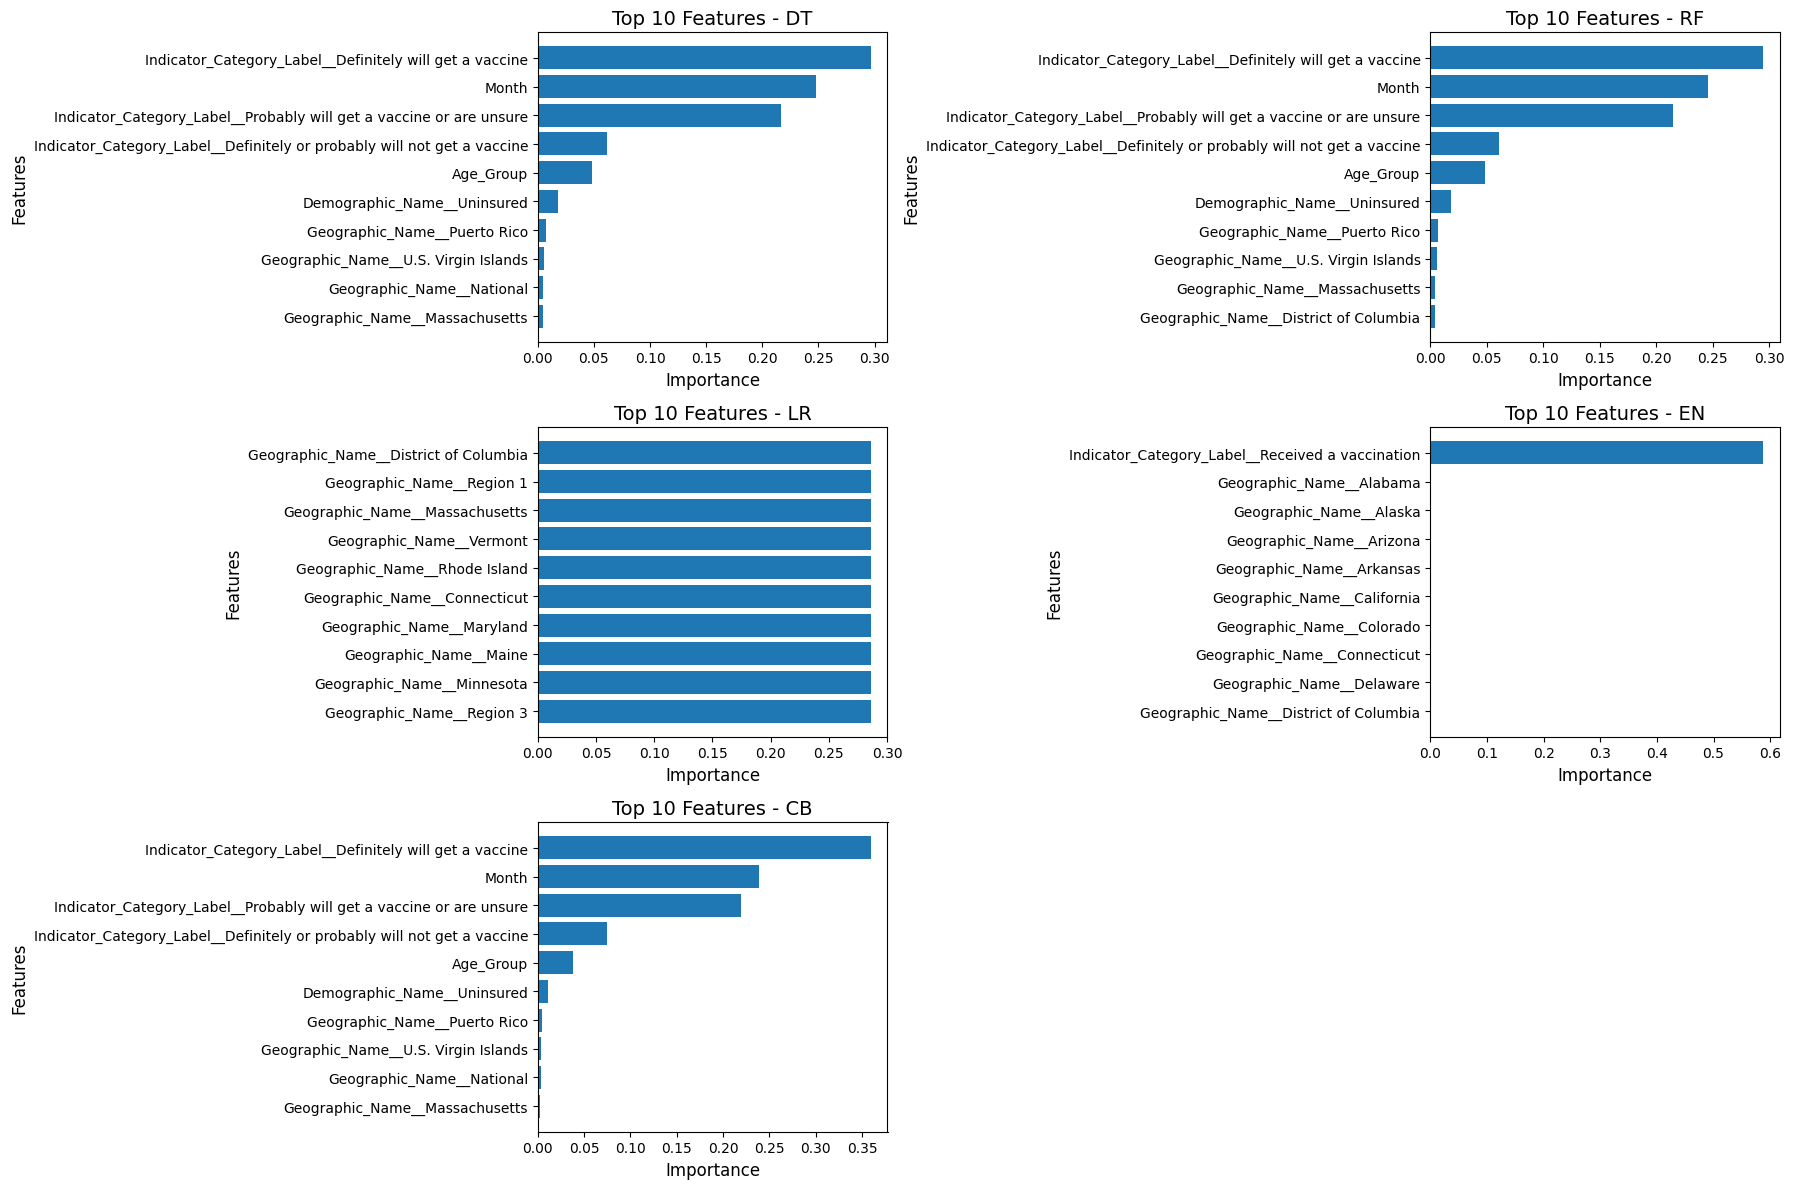

Top Features List:
DT: ['Indicator_Category_Label__Definitely will get a vaccine', 'Month', 'Indicator_Category_Label__Probably will get a vaccine or are unsure', 'Indicator_Category_Label__Definitely or probably will not get a vaccine', 'Age_Group', 'Demographic_Name__Uninsured', 'Geographic_Name__Puerto Rico', 'Geographic_Name__U.S. Virgin Islands', 'Geographic_Name__National', 'Geographic_Name__Massachusetts']
RF: ['Indicator_Category_Label__Definitely will get a vaccine', 'Month', 'Indicator_Category_Label__Probably will get a vaccine or are unsure', 'Indicator_Category_Label__Definitely or probably will not get a vaccine', 'Age_Group', 'Demographic_Name__Uninsured', 'Geographic_Name__Puerto Rico', 'Geographic_Name__U.S. Virgin Islands', 'Geographic_Name__Massachusetts', 'Geographic_Name__District of Columbia']
LR: ['Geographic_Name__District of Columbia', 'Geographic_Name__Region 1', 'Geographic_Name__Massachusetts', 'Geographic_Name__Vermont', 'Geographic_Name__Rhode Island', 'Ge

In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_features_imp['LR_importances'] = scaler.fit_transform(df_features_imp[['LR_importances']])

models = ['DT_importances', 'RF_importances', 'LR_importances', 'EN_importances', 'CB_importances']
num_features = 10
top_features_list = {}

plt.figure(figsize=(18, 12))

for i, model in enumerate(models):
    top_features = df_features_imp.nlargest(num_features, model)
    top_features_list[model] = top_features['Feature_list'].tolist()

    plt.subplot(3, 2, i + 1)
    plt.barh(top_features['Feature_list'], top_features[model])
    plt.title(f'Top 10 Features - {model[:-12]}', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("Top Features List:")
for model, features in top_features_list.items():
    print(f"{model[:-12]}: {features}")

In [97]:
df_pred_test['Error_LR'] = abs(df_pred_test['Predictions_LR'] - df_pred_test['ND_Weekly_Estimate'])
df_pred_test['Error_DT'] = abs(df_pred_test['Predictions_DT'] - df_pred_test['ND_Weekly_Estimate'])
df_pred_test['Error_RF'] = abs(df_pred_test['Predictions_RF'] - df_pred_test['ND_Weekly_Estimate'])
df_pred_test['Error_EN'] = abs(df_pred_test['Predictions_EN'] - df_pred_test['ND_Weekly_Estimate'])
df_pred_test['Error_CB'] = abs(df_pred_test['Predictions_CB'] - df_pred_test['ND_Weekly_Estimate'])

worst_performers_dt = df_pred_test.nlargest(10, 'Error_DT')
worst_performers_rf = df_pred_test.nlargest(10, 'Error_RF')
worst_performers_lr = df_pred_test.nlargest(10, 'Error_LR')
worst_performers_en = df_pred_test.nlargest(10, 'Error_EN')
worst_performers_cb = df_pred_test.nlargest(10, 'Error_CB')

columns_to_display = ['ND_Weekly_Estimate', 'Predictions_DT', 'Predictions_RF', 'Predictions_LR', 'Predictions_EN', 'Predictions_CB']

with pd.option_context('display.width', 1000):
    print("Worst Performing Data Points for DT:")
    print(worst_performers_dt[columns_to_display])

    print("\nWorst Performing Data Points for RF:")
    print(worst_performers_rf[columns_to_display])

    print("\nWorst Performing Data Points for LR:")
    print(worst_performers_lr[columns_to_display])

    print("\nWorst Performing Data Points for EN:")
    print(worst_performers_en[columns_to_display])

    print("\nWorst Performing Data Points for CB:")
    print(worst_performers_cb[columns_to_display])

Worst Performing Data Points for DT:
       ND_Weekly_Estimate  Predictions_DT  Predictions_RF  Predictions_LR  Predictions_EN  Predictions_CB
8337                 17.6       46.600000       42.903421       13.283203       26.262005       35.622500
11836                13.4       42.300000       40.455343       28.948730       28.920491       35.184774
1190                 43.1       14.800000       18.819399       13.364258       29.679090       21.205386
3311                 46.9       20.233333       20.579008        6.021973       26.262005       24.695721
4065                 15.1       40.400000       35.980583       46.738281       30.092006       29.698604
10696                 8.6       33.200000       28.982761       33.391113       28.920491       27.236827
8126                 53.4       29.700000       29.558462       13.238281       26.262005       28.714309
3612                 14.5       36.600000       34.470260        9.724121       26.262005       27.500881
8330     

In [98]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=worst_performers_dt['ND_Weekly_Estimate'],
    y=worst_performers_dt['Predictions_DT'],
    mode='markers',
    name='Decision Tree Predictions',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=worst_performers_rf['ND_Weekly_Estimate'],
    y=worst_performers_rf['Predictions_RF'],
    mode='markers',
    name='Random Forest Predictions',
    marker=dict(color='orange', symbol='square')
))

fig.add_trace(go.Scatter(
    x=worst_performers_lr['ND_Weekly_Estimate'],
    y=worst_performers_lr['Predictions_LR'],
    mode='markers',
    name='Linear Regression Predictions',
    marker=dict(color='red', symbol='x')
))

fig.add_trace(go.Scatter(
    x=worst_performers_en['ND_Weekly_Estimate'],
    y=worst_performers_en['Predictions_EN'],
    mode='markers',
    name='Elastic Net Predictions',
    marker=dict(color='purple', symbol='diamond')
))

fig.add_trace(go.Scatter(
    x=worst_performers_cb['ND_Weekly_Estimate'],
    y=worst_performers_cb['Predictions_CB'],
    mode='markers',
    name='CatBoost Predictions',
    marker=dict(color='blue', symbol='star')
))

max_value = max(
    worst_performers_dt['ND_Weekly_Estimate'].max(),
    worst_performers_rf['ND_Weekly_Estimate'].max(),
    worst_performers_lr['ND_Weekly_Estimate'].max(),
    worst_performers_en['ND_Weekly_Estimate'].max(),
    worst_performers_cb['ND_Weekly_Estimate'].max(),
    worst_performers_dt['Predictions_DT'].max(),
    worst_performers_rf['Predictions_RF'].max(),
    worst_performers_lr['Predictions_LR'].max(),
    worst_performers_en['Predictions_EN'].max(),
    worst_performers_cb['Predictions_CB'].max()
)

min_value = min(
    worst_performers_dt['ND_Weekly_Estimate'].min(),
    worst_performers_rf['ND_Weekly_Estimate'].min(),
    worst_performers_lr['ND_Weekly_Estimate'].min(),
    worst_performers_en['ND_Weekly_Estimate'].min(),
    worst_performers_cb['ND_Weekly_Estimate'].min(),
    worst_performers_dt['Predictions_DT'].min(),
    worst_performers_rf['Predictions_RF'].min(),
    worst_performers_lr['Predictions_LR'].min(),
    worst_performers_en['Predictions_EN'].min(),
    worst_performers_cb['Predictions_CB'].min()
)

fig.add_trace(go.Scatter(
    x=[min_value, max_value],
    y=[min_value, max_value],
    mode='lines',
    name='Perfect Prediction Line',
    line=dict(color='black', dash='dash')
))

fig.update_layout(
    xaxis_title='Actual Values (ND Weekly Estimate)',
    yaxis_title='Predicted Values',
    title='Worst Performing Model Predictions Comparison',
    legend_title_text='Models',
    template='plotly_white'
)

fig.show()

In [99]:
columns_to_display = ['ND_Weekly_Estimate', 'Predictions_DT', 'Predictions_RF', 'Predictions_LR', 'Predictions_EN', 'Predictions_CB']

def display_worst_performers(worst_performers, model_name):
    indices = worst_performers.index
    feature_values = X_test.loc[indices]
    combined_df = pd.concat([worst_performers[columns_to_display], feature_values], axis=1)
    print(f"Worst performers for model {model_name}:")
    print(combined_df.to_string(index=True))
    print("\n" + "="*50 + "\n")


display_worst_performers(worst_performers_dt, 'DT')
display_worst_performers(worst_performers_rf, 'RF')
display_worst_performers(worst_performers_lr, 'LR')
display_worst_performers(worst_performers_en, 'EN')
display_worst_performers(worst_performers_cb, 'CB')

Worst performers for model DT:
       ND_Weekly_Estimate  Predictions_DT  Predictions_RF  Predictions_LR  Predictions_EN  Predictions_CB  Age_Group  Month  Geographic_Name__Alabama  Geographic_Name__Alaska  Geographic_Name__Arizona  Geographic_Name__Arkansas  Geographic_Name__California  Geographic_Name__Colorado  Geographic_Name__Connecticut  Geographic_Name__Delaware  Geographic_Name__District of Columbia  Geographic_Name__Florida  Geographic_Name__Georgia  Geographic_Name__Guam  Geographic_Name__Hawaii  Geographic_Name__Idaho  Geographic_Name__Illinois  Geographic_Name__Illinois-City of Chicago  Geographic_Name__Illinois-Rest of State  Geographic_Name__Indiana  Geographic_Name__Iowa  Geographic_Name__Kansas  Geographic_Name__Kentucky  Geographic_Name__Louisiana  Geographic_Name__Maine  Geographic_Name__Maryland  Geographic_Name__Massachusetts  Geographic_Name__Michigan  Geographic_Name__Minnesota  Geographic_Name__Mississippi  Geographic_Name__Missouri  Geographic_Name__Montana  Geo

In [100]:
best_performers_dt = df_pred_test.nsmallest(10, 'Error_DT')
best_performers_rf = df_pred_test.nsmallest(10, 'Error_RF')
best_performers_lr = df_pred_test.nsmallest(10, 'Error_LR')
best_performers_en = df_pred_test.nsmallest(10, 'Error_EN')
best_performers_cb = df_pred_test.nsmallest(10, 'Error_CB')
def display_best_performers(best_performers, model_name):
    indices = best_performers.index
    feature_values = X_test.loc[indices]
    combined_df = pd.concat([best_performers[columns_to_display], feature_values], axis=1)
    print(f"Best performers for model {model_name}:")
    print(combined_df.to_string(index=True))
    print("\n" + "="*50 + "\n")


display_best_performers(best_performers_dt, 'DT')
display_best_performers(best_performers_rf, 'RF')
display_best_performers(best_performers_lr, 'LR')
display_best_performers(best_performers_en, 'EN')
display_best_performers(best_performers_en, 'CB')

Best performers for model DT:
       ND_Weekly_Estimate  Predictions_DT  Predictions_RF  Predictions_LR  Predictions_EN  Predictions_CB  Age_Group  Month  Geographic_Name__Alabama  Geographic_Name__Alaska  Geographic_Name__Arizona  Geographic_Name__Arkansas  Geographic_Name__California  Geographic_Name__Colorado  Geographic_Name__Connecticut  Geographic_Name__Delaware  Geographic_Name__District of Columbia  Geographic_Name__Florida  Geographic_Name__Georgia  Geographic_Name__Guam  Geographic_Name__Hawaii  Geographic_Name__Idaho  Geographic_Name__Illinois  Geographic_Name__Illinois-City of Chicago  Geographic_Name__Illinois-Rest of State  Geographic_Name__Indiana  Geographic_Name__Iowa  Geographic_Name__Kansas  Geographic_Name__Kentucky  Geographic_Name__Louisiana  Geographic_Name__Maine  Geographic_Name__Maryland  Geographic_Name__Massachusetts  Geographic_Name__Michigan  Geographic_Name__Minnesota  Geographic_Name__Mississippi  Geographic_Name__Missouri  Geographic_Name__Montana  Geog

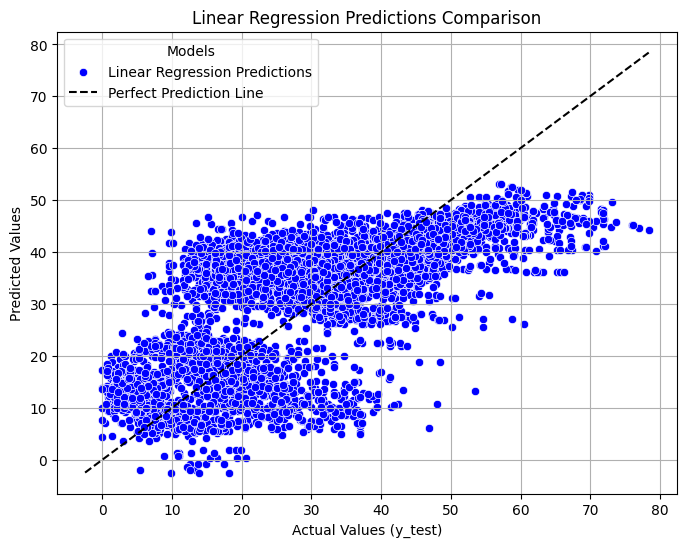

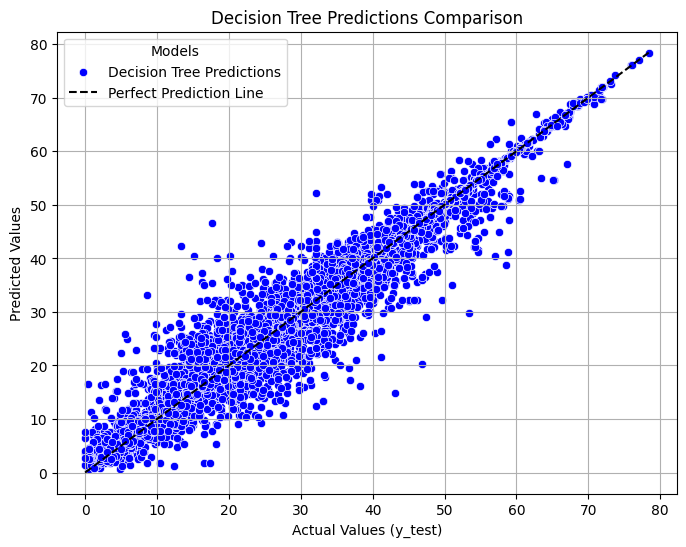

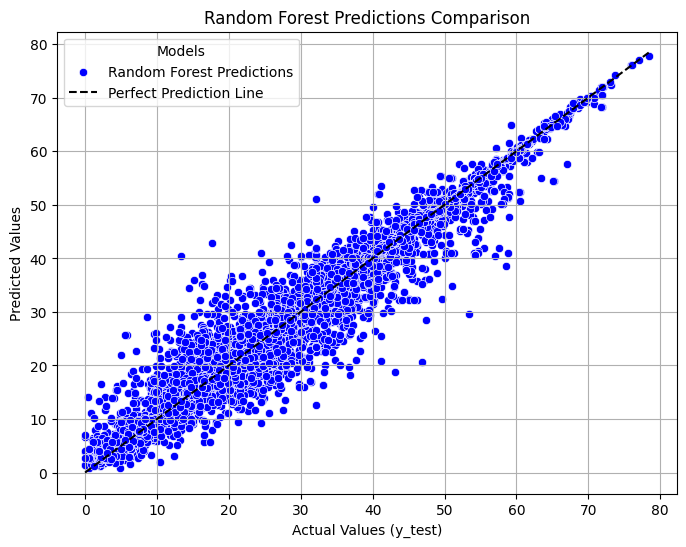

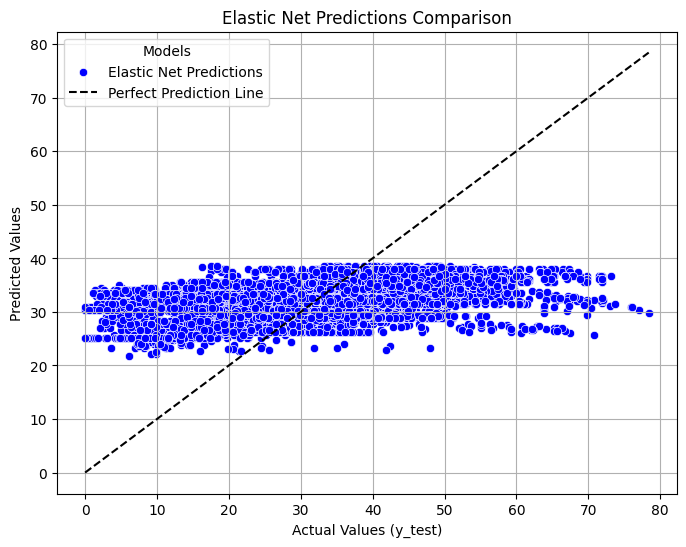

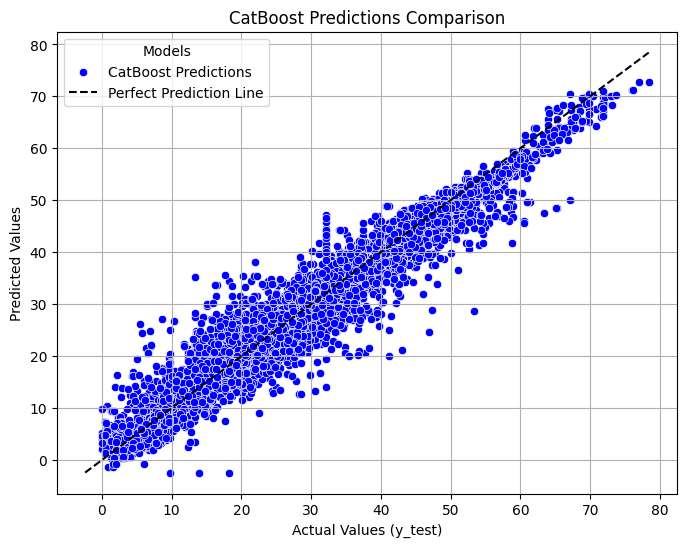

In [101]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Elastic Net', 'CatBoost']
predictions = [predictions_lr, predictions_dt, predictions_rf, predictions_en, predictions_cb]

for model, preds in zip(models, predictions):
    plt.figure(figsize=(8, 6))

    sns.scatterplot(x=y_test, y=preds, label=f'{model} Predictions', color='blue', marker='o')

    min_value = min(y_test.min(), preds.min())
    max_value = max(y_test.max(), preds.max())
    plt.plot([min_value, max_value], [min_value, max_value], 'k--', label='Perfect Prediction Line')

    plt.xlabel('Actual Values (y_test)')
    plt.ylabel('Predicted Values')
    plt.title(f'{model} Predictions Comparison')
    plt.legend(title='Models')
    plt.grid(True)

    plt.show()